In [22]:
# %load_ext lab_black

# help with installing prophet
https://medium.com/data-folks-indonesia/installing-fbprophet-prophet-for-time-series-forecasting-in-jupyter-notebook-7de6db09f93e

In [39]:
# %pip install numpy
# %pip install cython
# %pip install pystan
# %pip install prophet
# %pip install scikit-learn

In [1]:
import datetime
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

/Users/erinoefelein/.local/share/virtualenvs/gym-fog-8uz14OSv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Facebook Prophet 
is a  tool for time series forecasting, popular for its accuracy and ease of use. Based on an additive model, the model breaks down the timeseries forecast into different components.

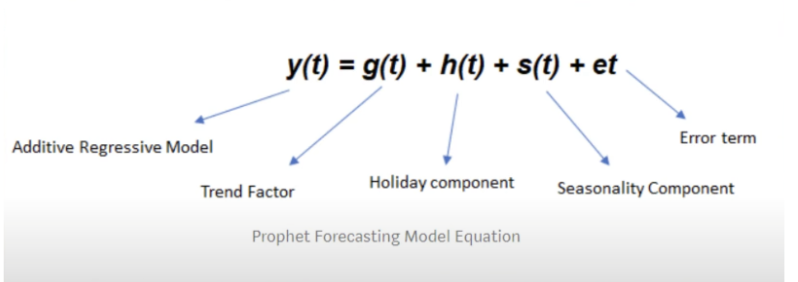

# Various Trends in Time Series Data
https://www.geeksforgeeks.org/components-of-time-series-data/

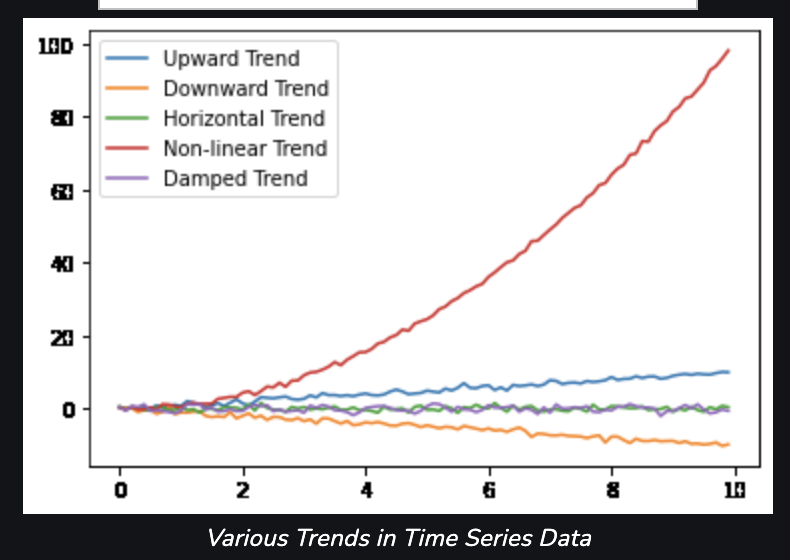

# Seasonality in Time Series Data
https://www.geeksforgeeks.org/components-of-time-series-data/

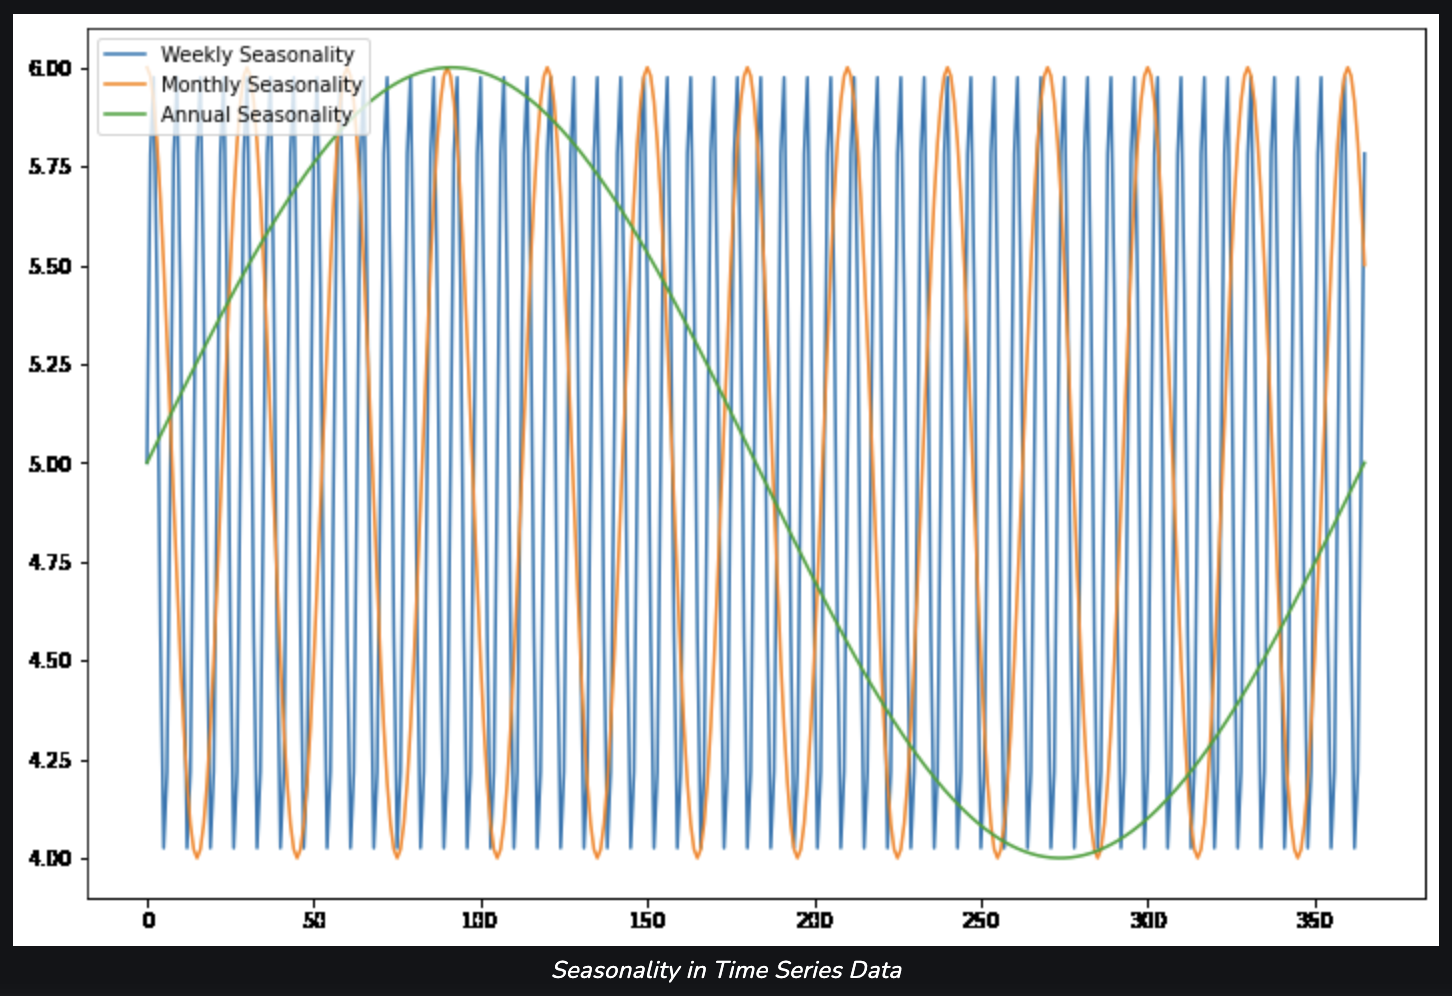

Here's a step-by-step guide to using Facebook Prophet to forecast hourly website traffic leading up to tax day:

## The Data

You are provided with timeseries data to use. A summary and preview are provided below.

# Mockseries.csv

| Column     | Description              |
|------------|--------------------------|
| `'timestamp'` | Date and time at which point each observation was captured. |
| `'max_ol_user_count'` | Maximum number of concurrent online users. |
| `'activity_tax_year_num'` | Tax year identifier. |
| `'days_to_tax_day'` | Number of days until Tax Day. |

In [2]:
def process_data(filename, tax_year):
    # read data
    sim_ty = pd.read_csv(filename, sep=";", header=None).rename(
        columns={0: "timestamp", 1: "max_ol_user_count"}
    )
    sim_ty["max_ol_user_count"] = np.floor(sim_ty["max_ol_user_count"] * 1000)
    sim_ty["activity_tax_year_num"] = tax_year
    sim_ty["days_to_tax_day"] = [3] * 24 + [2] * 24 + [1] * 24 + [0] * 24
    return sim_ty


timeseries = pd.concat(
    [
        process_data("TY15_mockseries.csv", 2015),
        process_data("TY18_mockseries.csv", 2018),
        process_data("TY20_mockseries.csv", 2020),
    ]
).reset_index(drop=True)
# display
timeseries

,timestamp,max_ol_user_count,activity_tax_year_num,days_to_tax_day
0,2016-04-15 00:00:00,9858.0,2015,3
1,2016-04-15 01:00:00,12360.0,2015,3
2,2016-04-15 02:00:00,14755.0,2015,3
3,2016-04-15 03:00:00,17280.0,2015,3
4,2016-04-15 04:00:00,22944.0,2015,3
...,...,...,...,...
283,2021-05-17 19:00:00,87816.0,2020,0
284,2021-05-17 20:00:00,80168.0,2020,0
285,2021-05-17 21:00:00,56188.0,2020,0
286,2021-05-17 22:00:00,26254.0,2020,0


# to plot, we can pivot the dataframe

In [3]:
timeseries[["date", "time"]] = timeseries["timestamp"].str.split(" ", expand=True)
timeseries["uniqueID"] = timeseries["days_to_tax_day"].astype(str) + "_" + timeseries["time"].astype(str)
# pivot
timeseries_pivot = timeseries.pivot(index='uniqueID', columns='activity_tax_year_num', values='max_ol_user_count').reset_index(drop=True)
# display
timeseries_pivot

activity_tax_year_num,2015,2018,2020
0,12232.0,11279.0,12415.0
1,15035.0,14557.0,11689.0
2,9265.0,14154.0,13931.0
3,15453.0,17102.0,19630.0
4,21247.0,21823.0,21755.0
...,...,...,...
91,89494.0,87506.0,83604.0
92,82109.0,82904.0,81942.0
93,61844.0,60729.0,60973.0
94,25902.0,27878.0,29476.0


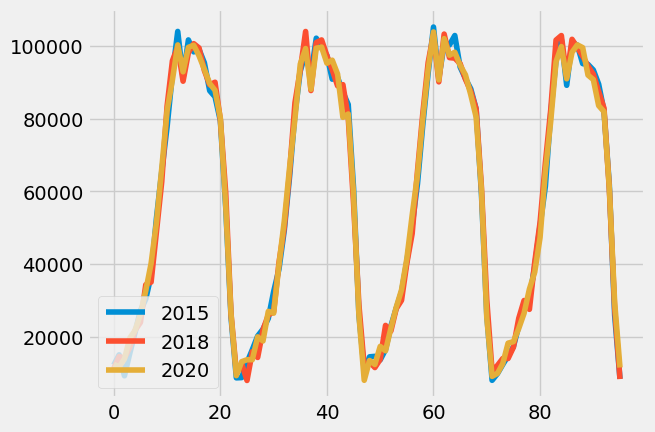

In [4]:
timeseries_pivot.plot()
# plot
plt.legend(loc='lower left')

# add regressor
In Facebook Prophet, the regressor component allows you to incorporate additional information that might influence your target variable beyond the built-in trend,seasonality, and any added holiday effects. Here's how it works:
<br>
During model fitting, Prophet learns the relationship between the regressor and the target by analyzing the target and regressor data. It tries to understand how changes in the regressor variable might affect the target variable. Once trained, Prophet uses this learned relationship to adjust its predictions. If the regressor variable suggests a potential increase (or decrease) in the target variable, this will be reflected in the forecast that Prophet generates.

In [5]:
is_tax_day = ([False] * 72 + [True] * 24) # each tax year consists of 96 hours
timeseries['is_tax_day'] = (is_tax_day) * 3 # multiplied over 3 years

In [6]:
df = timeseries[['timestamp','max_ol_user_count','is_tax_day']].rename(columns={'timestamp':'ds','max_ol_user_count':'y'})
# display
df_train = df.iloc[:int(len(df) * 0.7), :]
df_test = df.iloc[int(len(df) * 0.7):, :]

In [7]:
# define the model
model = Prophet(daily_seasonality=True)

In [8]:
dir(model) # set these according to your data

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_stan_backend',
 '_logistic_uncertainty',
 '_make_historical_mat_time',
 '_make_trend_shift_matrix',
 '_sample_uncertainty',
 'add_country_holidays',
 'add_group_component',
 'add_regressor',
 'add_seasonality',
 'calculate_initial_params',
 'changepoint_prior_scale',
 'changepoint_range',
 'changepoints',
 'changepoints_t',
 'component_modes',
 'construct_holiday_dataframe',
 'country_holidays',
 'daily_seasonality',
 'extra_regressors',
 'fit',
 'fit_kwargs',
 'flat_growth_init',
 'flat_trend',
 'fourier_series',
 'growth',
 'history',
 'history_dates',
 'holidays',
 'holidays_mode',
 'holidays_prior_scale',
 'ini

Changepoints refer to specific points in time where the statistical properties of the data change significantly. Visually, a changepoint would be a point where the line representing the data abruptly shifts direction (upward or downward).
<br>
Changepoints signal a shift in the underlying process that generates the data. According to different domains, we may see changepoints manifest in the following ways:
<br>
 - Finance: Detecting changes in stock market volatility or market trends.
 - Climate science: Identifying shifts in weather patterns or climate change.
 - Epidemiology: Tracking the spread of diseases and detecting outbreaks.
 - Quality control: Identifying changes in product quality or manufacturing processes.

In [9]:
# add regressor
model.add_regressor("is_tax_day")
# fit the model
model.fit(df_train)

14:17:32 - cmdstanpy - INFO - Chain [1] start processing
14:17:33 - cmdstanpy - INFO - Chain [1] done processing


# Forecast

In [11]:
predictions = model.predict(df_test)

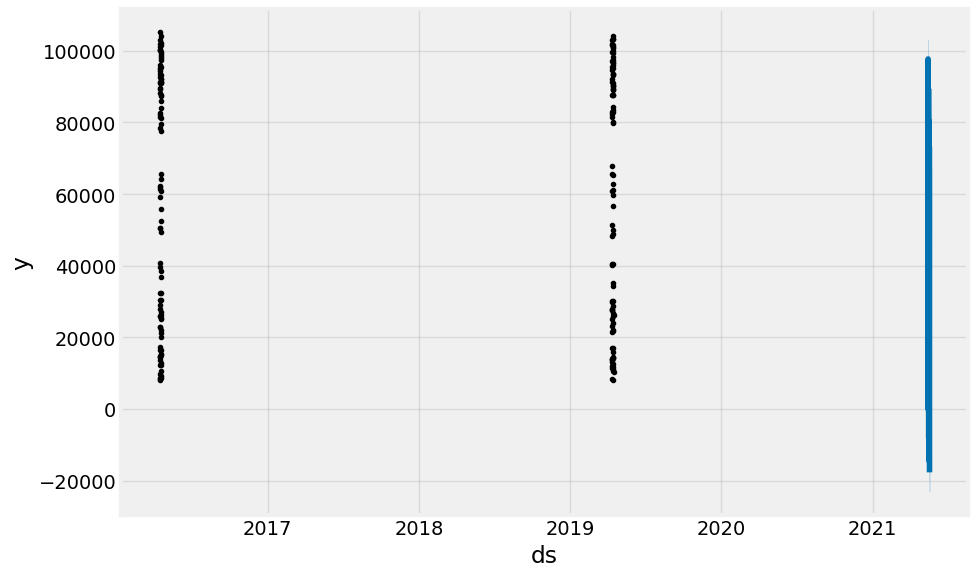

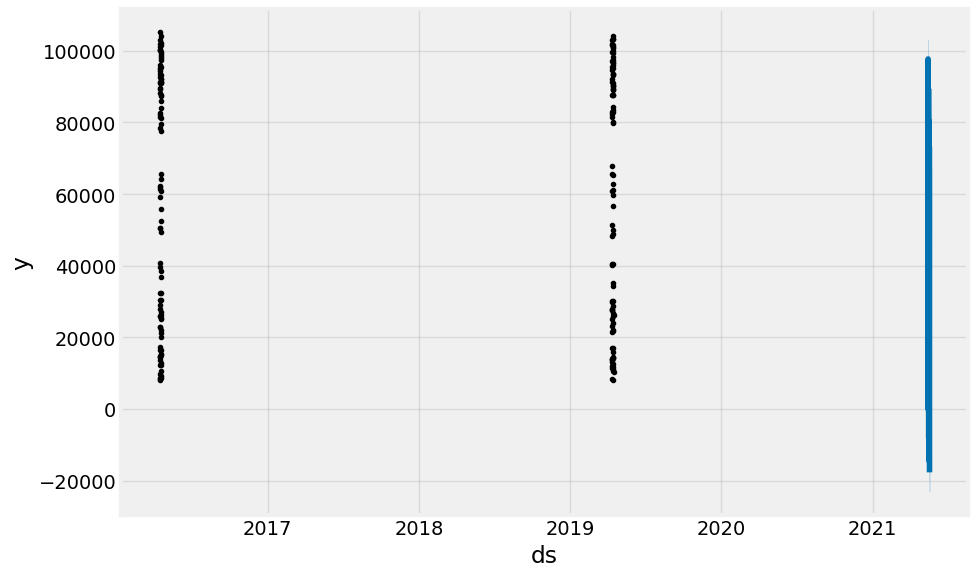

In [12]:
# plot forecast
model.plot(predictions)

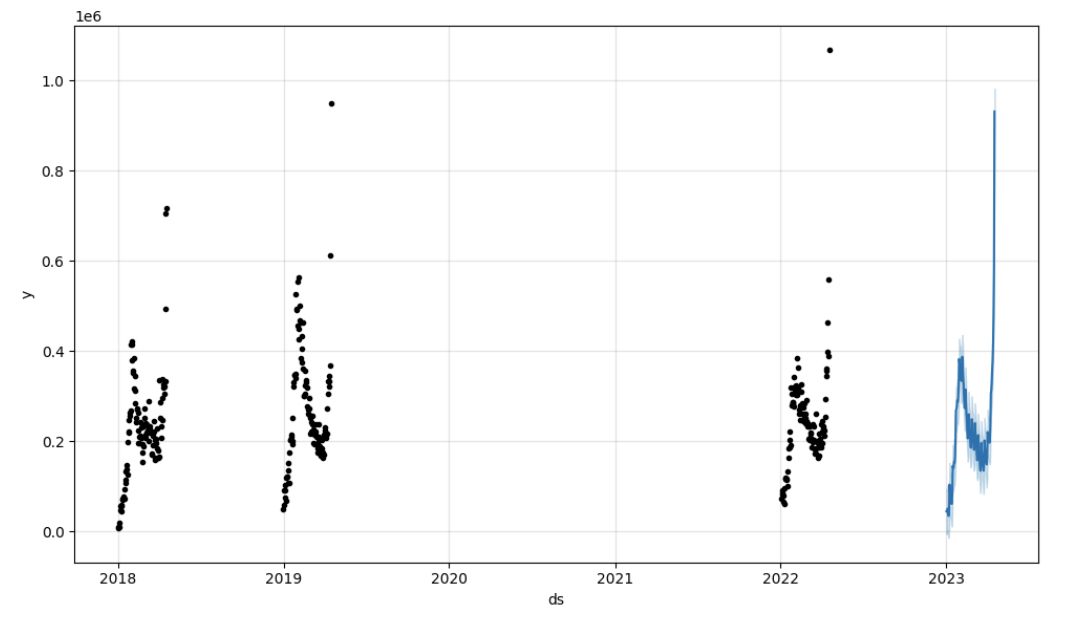

### Note the confidence intervals, which indicate the upper and lower bounds of what the model thinks falls within the bounds of a reasonable prediction.
As you predict further into the future, you'll see that confidence intervals get wider (as the model becomes less certain of its predictions).

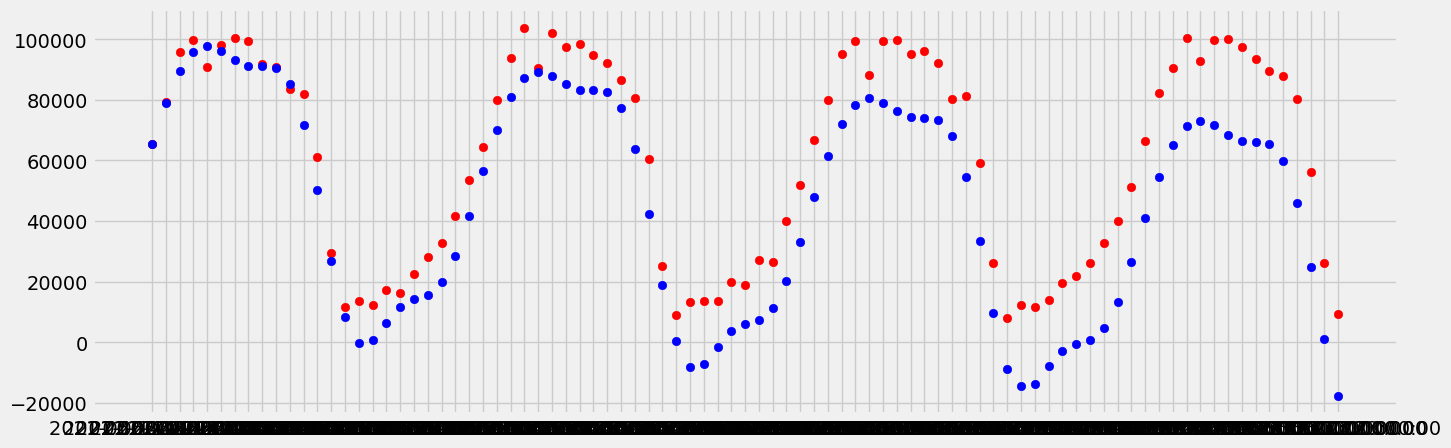

In [14]:
f, ax = plt.subplots(figsize=(15,5))
ax.scatter(df_test['ds'], df_test['y'], color='r') # actual in red
ax.scatter(df_test['ds'], predictions['yhat'], color='b') # predicted in blue

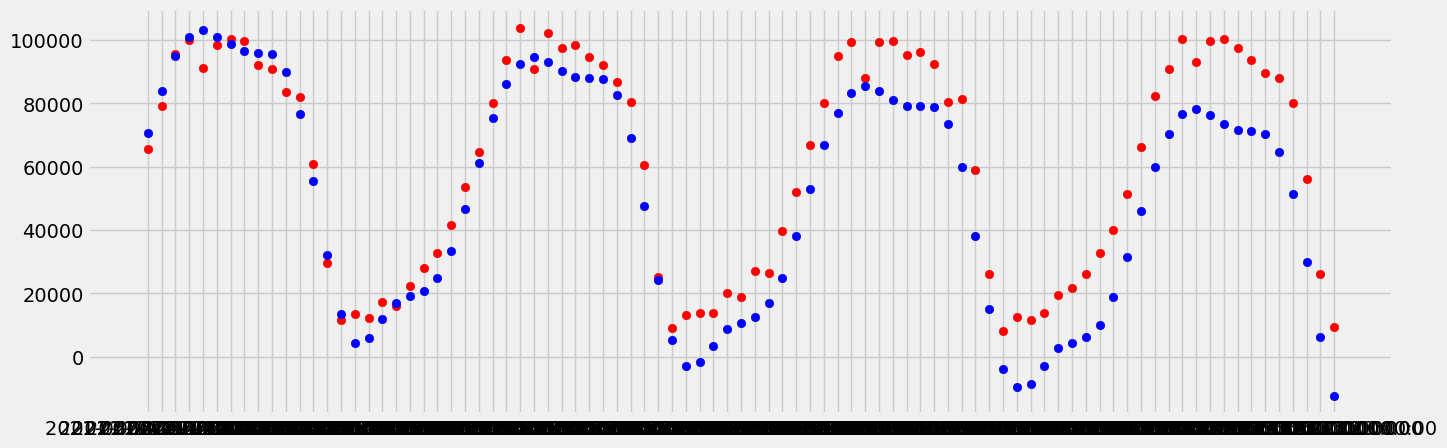

In [15]:
f, ax = plt.subplots(figsize=(15,5))
ax.scatter(df_test['ds'], df_test['y'], color='r') # actual in red
ax.scatter(df_test['ds'], predictions['yhat_upper'], color='b') # predicted in blue

# Evaluate with Error Metrics

In [69]:
np.sqrt(mean_squared_error(y_true = df_test['y'], y_pred= y_pred['yhat_upper'])) # RMSE

14390.92455319992

In [70]:
mean_absolute_error(y_true = df_test['y'], y_pred= y_pred['yhat_upper']) # MAE

12269.809106022478

In [73]:
mean_absolute_percentage_error(y_true = df_test['y'], y_pred= y_pred['yhat_upper']) # percent off on average

0.3483841785366016

# Apply to entire training set to predict 2024

In [16]:
# Create Future DataFrame

start_date = pd.Timestamp('2024-04-12 00:00:00')  # Midnight on Friday, April 12, 2024
# Define hourly frequency
freq = 'H'
# Define length (96 hours)
period = 96
# Use date_range to create a DatetimeIndex
ds = pd.date_range(start_date, periods=period, freq=freq)
# create future dataframe
future = pd.concat([pd.Series(ds), pd.Series(is_tax_day)], axis=1).rename(columns={0:'ds', 1:'is_tax_day'})

In [24]:
# model.make_future_dataframe(periods=96, include_history=False, freq='h')

,ds
0,2021-05-18 00:00:00
1,2021-05-18 01:00:00
2,2021-05-18 02:00:00
3,2021-05-18 03:00:00
4,2021-05-18 04:00:00
...,...
91,2021-05-21 19:00:00
92,2021-05-21 20:00:00
93,2021-05-21 21:00:00
94,2021-05-21 22:00:00


In [17]:
ty15 = pd.DataFrame({'holiday': "Tax Day", 'ds' : pd.to_datetime(['2016-04-17'])}) 
ty18 = pd.DataFrame({'holiday': "Tax Day", 'ds' : pd.to_datetime(['2019-04-15'])})  
ty21 = pd.DataFrame({'holiday': "Tax Day", 'ds' : pd.to_datetime(['2021-05-17'])})  

us_tax_days = pd.concat([ty15,ty18,ty21]).reset_index(drop=True)

In [18]:
# define the model
model = Prophet(daily_seasonality=True, holidays=us_tax_days)
# add regressors
# model.add_regressor("is_tax_day")
# fit the model
model.fit(df.drop(['is_tax_day'], axis=1))

14:19:31 - cmdstanpy - INFO - Chain [1] start processing
14:19:31 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
forecast = model.predict(future)
# display
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Tax Day,Tax Day_lower,Tax Day_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-04-12 00:00:00,21673.319254,1848.297021,12360.607574,21673.319254,21673.319254,0.0,0.0,0.0,-14448.220330,...,3776.026882,3776.026882,3776.026882,33209.218169,33209.218169,33209.218169,0.0,0.0,0.0,7225.098923
1,2024-04-12 01:00:00,21673.273061,3476.528864,13354.012895,21673.273061,21673.273061,0.0,0.0,0.0,-13041.097834,...,3624.300471,3624.300471,3624.300471,33187.850828,33187.850828,33187.850828,0.0,0.0,0.0,8632.175227
2,2024-04-12 02:00:00,21673.226868,9499.961216,19631.945448,21673.226868,21673.226868,0.0,0.0,0.0,-7046.248183,...,3469.933246,3469.933246,3469.933246,33166.485368,33166.485368,33166.485368,0.0,0.0,0.0,14626.978685
3,2024-04-12 03:00:00,21673.180675,14667.431179,24892.527271,21673.180675,21673.180675,0.0,0.0,0.0,-1822.657109,...,3315.541146,3315.541146,3315.541146,33145.123140,33145.123140,33145.123140,0.0,0.0,0.0,19850.523566
4,2024-04-12 04:00:00,21673.134482,17018.817034,26946.597258,21673.134482,21673.134482,0.0,0.0,0.0,554.253143,...,3163.596156,3163.596156,3163.596156,33123.765483,33123.765483,33123.765483,0.0,0.0,0.0,22227.387624


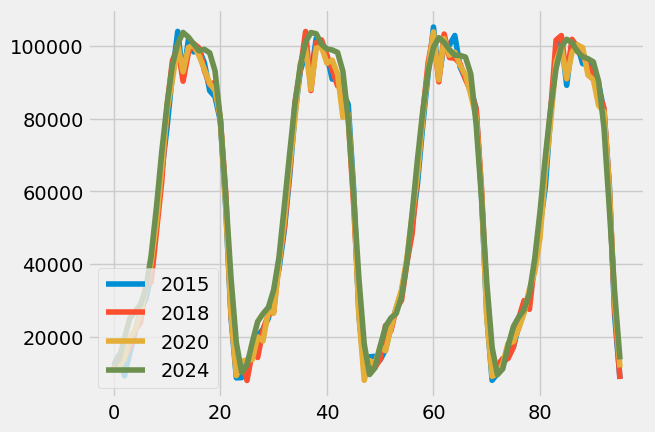

In [21]:
timeseries_pivot[2024] = np.ceil(forecast['yhat_upper']).tolist()
timeseries_pivot.plot()
plt.legend(loc='lower left')